<a href="https://colab.research.google.com/github/kiyong21c/pytorch_tutorial/blob/main/20220709_Feedforward.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

cuda
torch.Size([100, 1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([28, 28])
torch.Size([100])


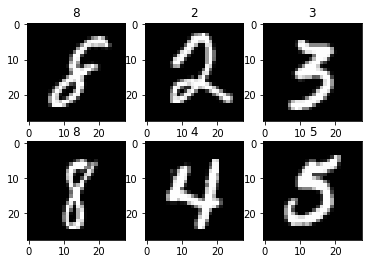

Epoch [1/2], Step [100/600], Loss: 0.4127
Epoch [1/2], Step [200/600], Loss: 0.2909
Epoch [1/2], Step [300/600], Loss: 0.2893
Epoch [1/2], Step [400/600], Loss: 0.0875
Epoch [1/2], Step [500/600], Loss: 0.1611
Epoch [1/2], Step [600/600], Loss: 0.2755
Epoch [2/2], Step [100/600], Loss: 0.1825
Epoch [2/2], Step [200/600], Loss: 0.1843
Epoch [2/2], Step [300/600], Loss: 0.0709
Epoch [2/2], Step [400/600], Loss: 0.1753
Epoch [2/2], Step [500/600], Loss: 0.0486
Epoch [2/2], Step [600/600], Loss: 0.1721


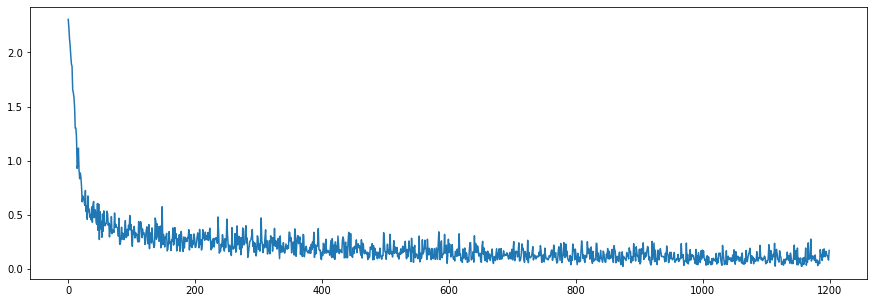

In [17]:
# feedforward

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

# Hyper-parameters 
input_size = 784 # 28x28
hidden_size = 500 
num_classes = 10
num_epochs = 2
batch_size = 100
learning_rate = 0.001

# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='./data',   # 저장 경로
                                           train=True,      # True : 훈련용 데이터 로드
                                           transform=transforms.ToTensor(),  # 이미지 파일을 텐서 형태로
                                           # 일반 이미지는 0-255사이의 값을 갖고, (H, W, C)의 형태를 갖는 반면 pytorch는 0-1사이의 값을 가지고 (C, H, W)의 형태를 갖는다
                                           download=True)   # 데이터셋이 없는경우 다운로드

test_dataset = torchvision.datasets.MNIST(root='./data',    
                                          train=False,      # False : 테스트용 데이터 로드
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)


examples = iter(train_loader) # generator -> iter타입 변경
example_data, example_targets = examples.next() # 하나 까보자

print(example_data.shape) # torch.Size([100, 1, 28, 28]) : 배치크기(100), 채널(1), 가로(28), 세로(28)
print(example_data[0].shape) # torch.Size([1, 28, 28]) : 첫번째 배치의 shape
print(example_data[0][0].shape) # torch.Size([28, 28]) : 첫번째 배치의, 첫채널(0번째 차원)의 shape

print(example_targets.shape) # torch.Size([100])

for i in range(6):
    plt.subplot(2,3,i+1)  # 함수형 방식
    plt.title(f'{example_targets[i]}')
    plt.imshow(example_data[i][0], cmap='gray') # 하나의 배치(100) 중 처음 6개의 이미지만 보자
    # train_loader에서 하나의 배치(100개데이터)를 가져와서 i번째 이미지의 0번째 차원인 흑백이미지(28X28)
plt.show()

# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.input_size = input_size
        self.l1 = nn.Linear(input_size, hidden_size) # 입력층
        self.relu = nn.ReLU()   # 층을 만들어 사용하는 방식
        self.l2 = nn.Linear(hidden_size, num_classes) # 출력층
    
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        # no activation and no softmax at the end
        return out

# 학습전 모델(입력사이즈, 은닉층크기, 출력층 설정)
model = NeuralNet(input_size, hidden_size, num_classes).to(device) # 모델을 to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss() # 모델에서 softmax 적용안한 이유
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # 옵티마이저에 모델의 파라미터(w,b), lr 전달

# Train the model
loss_list = []
n_total_steps = len(train_loader) # 전체 데이터가 배치사이즈 몇번으로 나뉘는지 
for epoch in range(num_epochs):     # 전체 데이터를 몇번 반복 할지
    for i, (images, labels) in enumerate(train_loader):  
        # images : [100, 1, 28, 28]
        # images(resized) : [100, 784], 100개의 이미지(각 784픽셀)
        images = images.reshape(-1, 28*28).to(device) # 100개의 이미지 device 전달
        labels = labels.to(device) # 100개의 레이블 device 전달
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.cpu().data) # loss(CUDA Tensor)를 loss(CPU Numpy)로 변환해서 사용
        # Backward and optimize
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

# loss 변화 plot
fig = plt.figure(figsize=(15, 5))
plt.plot(range(n_total_steps * num_epochs), loss_list)

In [21]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
# 테스트데이터로 예측값 확인할때는 backward(역전파)하면서 가중치를 수정하는것이 아니기 때문에 gradients계산 필요X
with torch.no_grad():
    n_correct = 0 # 예측과 타깃값이 일치하는 개수 초기화
    n_samples = 0 # 데이터 수 초기화
    for images, labels in test_loader:  # enumerate 사용X : i를 이용해 epoch/step별로 loss확인할 필요 없으므로
        images = images.reshape(-1, 28*28).to(device) # [100, 1, 28, 28] → [100, 784]
        labels = labels.to(device)
        outputs = model(images)
        # print(outputs.data.shape) # [100, 10] : 하나의배치(100개)데이터 각각 10개의 확률을 가짐
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, dim=1) # 10개의 확률중 가장 큰 값의 인덱스(를 100개 뽑음:배치크기)
        # predicted.shape : torchsize([100])
        # 마지막 출력층의 노드는 10개이며, 10개의 값 중 가장 큰 값(softmax는 적용하지 않음)의 인덱스를 뽑는다.(근데 하나의배치가 100개이므로 100번 뽑는다.)

        n_samples += labels.size(0) # size(0) : shape에서 0차원의 정수값
        # print((predicted == labels).sum())
        n_correct += (predicted == labels).sum().item() # tensor(100, device='cuda:0')에서 값만 가져오기
        # 하나의배치(100개)가 labels(100개)와 일치하는것들만 카운트
        # break   # test_loader의 batch 한개만 살펴보자
    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')

Accuracy of the network on the 10000 test images: 96.77 %
